In [1]:
import sys
sys.path.append("./utls")
sys.path.append("./preprocessing")
from preprocessing import *
import os
import string
import subprocess
from natsort import natsorted
from InterfaceDeclaration import LPBFData
from utls.preprocessing import MaPS_LPBF_Construction
from utls.preprocessing import fill_nan
from construct_roi_adjacent_labels import fourier_transform1d_interp
import pickle
import pandas as pd

alphabet = list(string.ascii_lowercase)

project_name = ["MuSIC", "MaPS", "MuSIC_EXP1"]
if os.name == "posix":
    data_dir = subprocess.getoutput("echo $DATADIR")
elif os.name == "nt":
    data_dir = subprocess.getoutput("echo %datadir%")
music_dir = os.path.join(data_dir, "MuSIC")
if not os.path.exists(music_dir):
    project_name[0] = "2024-MUSIC"
daq_dir = os.path.join(data_dir, *project_name, "Acoustic Monitoring")
lmq_dir = os.path.join(data_dir, *project_name, "LMQ Monitoring")
del music_dir

sampling_rate_daq: int = int(1.25 * 1e6)
sampling_rate_lmq: int = int(0.1 * 1e6)
tdms_daq_list = natsorted(
    [i for i in os.listdir(daq_dir) if i.split(".")[-1] == "tdms"]
)
bin_lmq_list = natsorted([i for i in os.listdir(lmq_dir) if i.split(".")[-1] == "bin"])
lmq_channel_name = [
    "Vector ID",
    "meltpooldiode",
    "X Coordinate",
    "Y Coordinate",
    "Laser power",
    "Spare",
    "Laser diode",
    "Varioscan(focal length)",
]
with open(os.path.join(os.path.dirname(daq_dir),'intermediate',f"lpbf_line_wise_data.pkl"), "rb") as fp:   
    lpbf_data = pickle.load(fp)

target_freq = 600000
target_length = 6000
common_freqs = np.linspace(0, target_freq, target_length)
scanning_vector = np.asarray(np.round(lpbf_data.print_vector[1]),dtype=int)
lpbf_data.print_vector = scanning_vector
uni_direction = list(np.unique(scanning_vector))
uni_direction.pop(2)
uni_position = range(5)
uni_direction

populations = []
for _c,_u in enumerate([-150,30,-60,120]):
    _AE_i = (np.where(scanning_vector==_u)[0])
    _AE = [lpbf_data.AE[i] for i in _AE_i]
    populations.append(len(_AE))

df_context = pd.DataFrame({
    "Direction":lpbf_data.print_vector, 
    "Position":lpbf_data.cube_position}
    )
df_context

,Direction,Position
0,30,0
1,-150,0
2,30,0
3,-150,0
4,30,0
...,...,...
124338,30,4
124339,-150,4
124340,30,4
124341,-150,4


In [2]:
_index = np.asarray(df_context[(df_context['Direction']==30) & (df_context['Position']==4)].index,dtype=int)
_index

array([   394,    396,    398, ..., 124338, 124340, 124342])

In [3]:
_AE = [lpbf_data.AE[i] for i in _index]
_ft = fourier_transform1d_interp(_AE,sampling_rate_daq,target_freq=target_freq,target_length=target_length, verbose=False)

In [4]:
def getFT_ae(i_r, i_c):
    _index = np.asarray(df_context[(df_context['Direction']==uni_direction[i_r]) & (df_context['Position']==uni_position[i_c])].index,dtype=int)
    _AE = [lpbf_data.AE[i] for i in _index]
    _ft = fourier_transform1d_interp(_AE,sampling_rate_daq,target_freq=target_freq,target_length=target_length, verbose=False)
    return _ft[0]

def getFT_mic(i_r, i_c):
    _index = np.asarray(df_context[(df_context['Direction']==uni_direction[i_r]) & (df_context['Position']==uni_position[i_c])].index,dtype=int)
    _AE = [lpbf_data.microphone[i] for i in _index]
    _ft = fourier_transform1d_interp(_AE,sampling_rate_daq,target_freq=target_freq,target_length=target_length, verbose=False)
    return _ft[0]

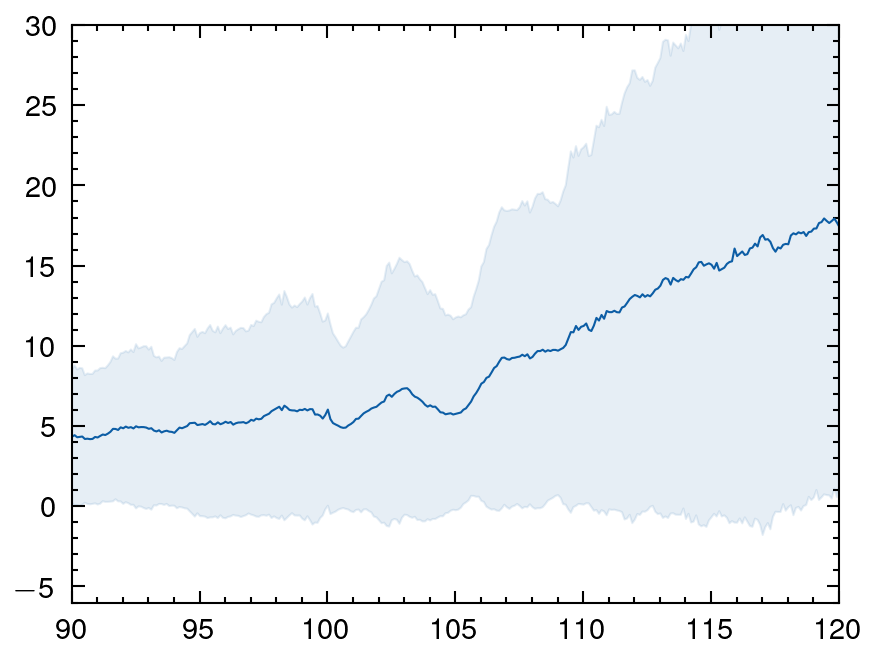

In [10]:
ft0 = []
i_r = 0
i_c = 2
_ft = getFT_ae(i_r,i_c)
_ft = np.where(np.isnan(_ft), 0, _ft)
mean_values = np.mean(np.abs(_ft), axis=0)
std_values = np.std(np.abs(_ft), axis=0)

fig,ax = plt.subplots()
ax.plot(common_freqs[10:]/1e3, mean_values[10:],lw=0.5)
ax.fill_between(common_freqs[10:]/1e3, (mean_values - std_values)[10:], (mean_values + std_values)[10:], color=cm_std[0], alpha=0.1, label="±1 STD",lw=0.5)
ax.set_ylim(-6,30)
ax.set_xlim(90,120)
plt.savefig(f"./outputs/raw_statistical_diff_ae_3_{i_r}.png",dpi=600)
plt.show()

c:\Users\mingwucn\.conda\envs\ai\Lib\site-packages\scipy\interpolate\_interpolate.py:712: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


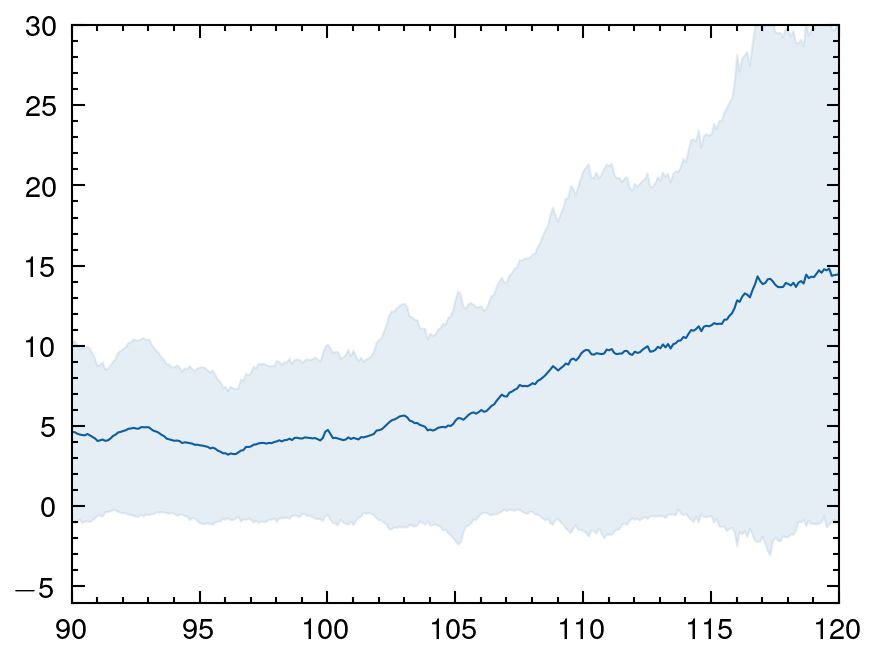

In [11]:
ft0 = []
i_r = 1
i_c = 2
_ft = getFT_ae(i_r,i_c)
_ft = np.where(np.isnan(_ft), 0, _ft)
mean_values = np.mean(np.abs(_ft), axis=0)
std_values = np.std(np.abs(_ft), axis=0)

fig,ax = plt.subplots()
ax.plot(common_freqs[10:]/1e3, mean_values[10:],lw=0.5)
ax.fill_between(common_freqs[10:]/1e3, (mean_values - std_values)[10:], (mean_values + std_values)[10:], color=cm_std[0], alpha=0.1, label="±1 STD",lw=0.5)
ax.set_ylim(-6,30)
ax.set_xlim(90,120)
plt.savefig(f"./outputs/raw_statistical_diff_ae_3_{i_r}.png",dpi=600)
plt.show()

c:\Users\mingwucn\.conda\envs\ai\Lib\site-packages\scipy\interpolate\_interpolate.py:712: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


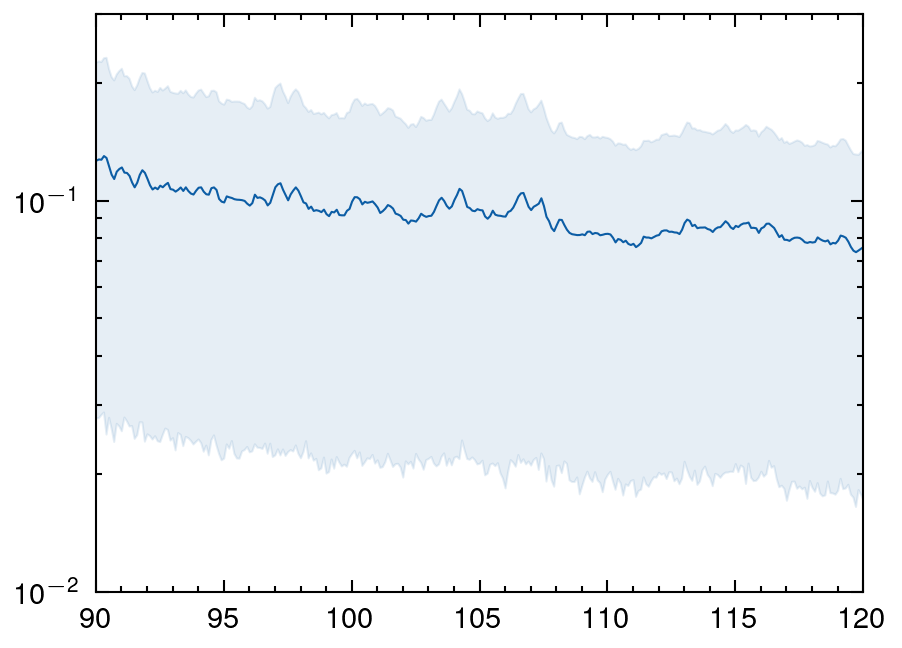

In [18]:
ft0 = []
i_r = 0
i_c = 2
_ft = getFT_mic(i_r,i_c)
_ft = np.where(np.isnan(_ft), 0, _ft)
mean_values = np.mean(np.abs(_ft), axis=0)
std_values = np.std(np.abs(_ft), axis=0)

fig,ax = plt.subplots()
ax.plot(common_freqs[10:]/1e3, mean_values[10:],lw=0.5)
ax.fill_between(common_freqs[10:]/1e3, (mean_values - std_values)[10:], (mean_values + std_values)[10:], color=cm_std[0], alpha=0.1, label="±1 STD",lw=0.5)
ax.set_ylim(0.01,0.3)
ax.set_xlim(90,120)
ax.set_yscale('log')
plt.savefig(f"./outputs/raw_statistical_diff_mic_3_{i_r}.png",dpi=600)
plt.show()

c:\Users\mingwucn\.conda\envs\ai\Lib\site-packages\scipy\interpolate\_interpolate.py:712: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


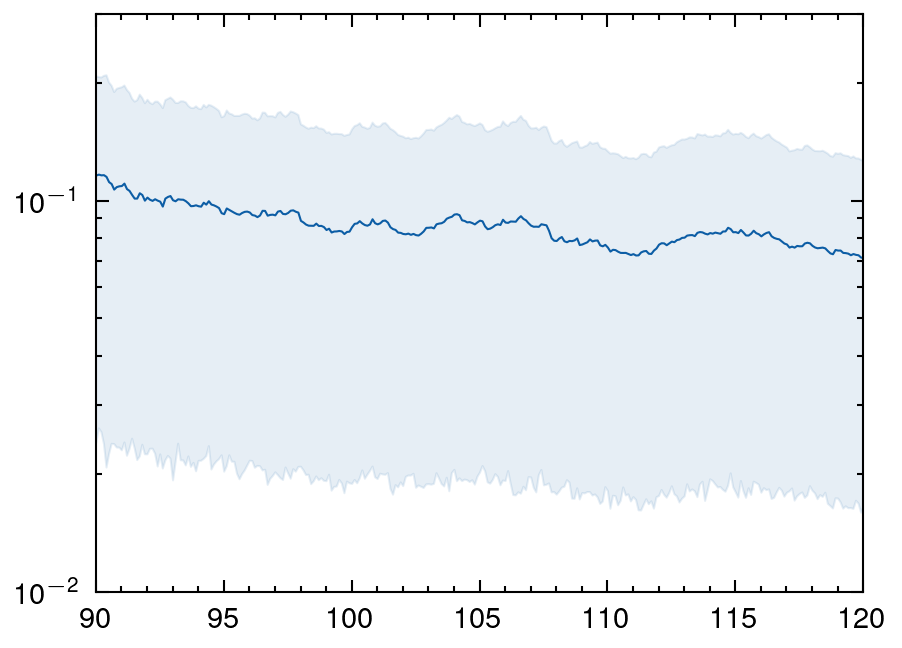

In [17]:
ft0 = []
i_r = 1
i_c = 2
_ft = getFT_mic(i_r,i_c)
_ft = np.where(np.isnan(_ft), 0, _ft)
mean_values = np.mean(np.abs(_ft), axis=0)
std_values = np.std(np.abs(_ft), axis=0)

fig,ax = plt.subplots()
ax.plot(common_freqs[10:]/1e3, mean_values[10:],lw=0.5)
ax.fill_between(common_freqs[10:]/1e3, (mean_values - std_values)[10:], (mean_values + std_values)[10:], color=cm_std[0], alpha=0.1, label="±1 STD",lw=0.5)
ax.set_ylim(0.01,0.3)
ax.set_xlim(90,120)
ax.set_yscale('log')
plt.savefig(f"./outputs/raw_statistical_diff_mic_3_{i_r}.png",dpi=600)
plt.show()

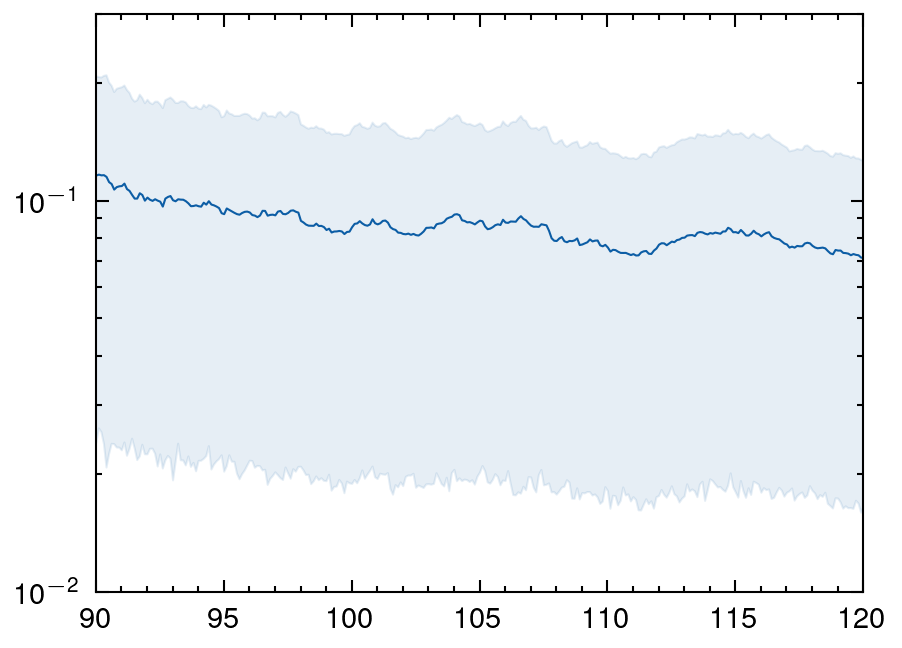

In [16]:
fig,ax = plt.subplots()
ax.plot(common_freqs[10:]/1e3, mean_values[10:],lw=0.5)
ax.fill_between(common_freqs[10:]/1e3, (mean_values - std_values)[10:], (mean_values + std_values)[10:], color=cm_std[0], alpha=0.1, label="±1 STD",lw=0.5)
ax.set_ylim(0.01,0.3)
ax.set_xlim(90,120)
ax.set_yscale('log')
plt.savefig(f"./outputs/raw_statistical_diff_mic_3_{i_r}.png",dpi=600)
plt.show()